# Train Model

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 6x24x24 → 6x12x12
        x = self.pool(torch.relu(self.conv2(x)))  # 16x8x8 → 16x4x4
        x = x.view(-1, 16 * 4 * 4)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Split training set into training and validation (90% train, 10% val)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to evaluate accuracy
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_acc = evaluate(model, trainloader, device)
    val_acc = evaluate(model, valloader, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

# Evaluate on test set
test_acc = evaluate(model, testloader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Save the model weights
torch.save(model.state_dict(), "lenet5.pth")
print("Model saved!")

Epoch 1/5, Loss: 0.3510, Train Acc: 96.13%, Val Acc: 95.88%
Epoch 2/5, Loss: 0.0974, Train Acc: 97.33%, Val Acc: 96.87%
Epoch 3/5, Loss: 0.0658, Train Acc: 98.33%, Val Acc: 97.97%
Epoch 4/5, Loss: 0.0521, Train Acc: 98.84%, Val Acc: 98.25%
Epoch 5/5, Loss: 0.0424, Train Acc: 98.85%, Val Acc: 98.23%
Test Accuracy: 98.60%
Model saved!


# Extract Weights

In [71]:
import torch
import numpy as np

model = LeNet5()
state_dict = torch.load('lenet5.pth', map_location=torch.device('cpu'), weights_only=True)  # Set weights_only=True
model.load_state_dict(state_dict)  # Load the state dictionary
model.eval()

# Extract the weights
conv1_weights = model.conv1.weight.data.numpy()  # Assuming 'conv1' is the first convolutional layer
conv1_biases = model.conv1.bias.data.numpy()
conv2_weights = model.conv2.weight.data.numpy()
conv2_biases = model.conv2.bias.data.numpy()
fc1_weights = model.fc1.weight.data.numpy()
fc1_biases = model.fc1.bias.data.numpy()
fc2_weights = model.fc2.weight.data.numpy()
fc2_biases = model.fc2.bias.data.numpy()
fc3_weights = model.fc3.weight.data.numpy()
fc3_biases = model.fc3.bias.data.numpy()

# Save weights as NumPy arrays
np.savez('lenet_weights.npz',
         conv1_weights=conv1_weights, conv1_biases=conv1_biases,
         conv2_weights=conv2_weights, conv2_biases=conv2_biases,
         fc1_weights=fc1_weights, fc1_biases=fc1_biases,
         fc2_weights=fc2_weights, fc2_biases=fc2_biases,
         fc3_weights=fc3_weights, fc3_biases=fc3_biases)

In [72]:
import numpy as np

# Load the weights
weights = np.load('lenet_weights.npz')

# Create a C header file to store the weights
with open('lenet_weights.h', 'w') as f:
    # Function to convert NumPy arrays to C arrays
    def array_to_c(array, name):
        def format_array(arr, indent=0):
            if arr.ndim == 1:  # Base case: 1D array
                return "{" + ", ".join(f"{x:.8f}" for x in arr) + "}"
            else:
                # Recursive case: Multi-dimensional array
                lines = [format_array(sub_arr, indent + 4) for sub_arr in arr]
                return "{\n" + ",\n".join(" " * (indent + 4) + line for line in lines) + "\n" + " " * indent + "}"

        shape_str = str(array.shape).replace('(', '[').replace(')', ']')
        shape_str = shape_str.replace(', ', '][')  # Replace commas with ][ for C array declaration
        # Remove trailing comma for 1D arrays
        if array.ndim == 1:
            shape_str = shape_str[:-2] + "]"  # Remove the trailing "]," and add "]"


        f.write(f"float {name}{shape_str} = ")
        f.write(format_array(array) + ";\n\n")

    # Convert and write the weights to the header file
    array_to_c(weights['conv1_weights'], 'conv1_weights')
    array_to_c(weights['conv1_biases'], 'conv1_biases')
    array_to_c(weights['conv2_weights'], 'conv2_weights')
    array_to_c(weights['conv2_biases'], 'conv2_biases')
    array_to_c(weights['fc1_weights'], 'fc1_weights')
    array_to_c(weights['fc1_biases'], 'fc1_biases')
    array_to_c(weights['fc2_weights'], 'fc2_weights')
    array_to_c(weights['fc2_biases'], 'fc2_biases')
    array_to_c(weights['fc3_weights'], 'fc3_weights')
    array_to_c(weights['fc3_biases'], 'fc3_biases')

print("Weights saved to lenet_weights.h")

Weights saved to lenet_weights.h


# Export Image

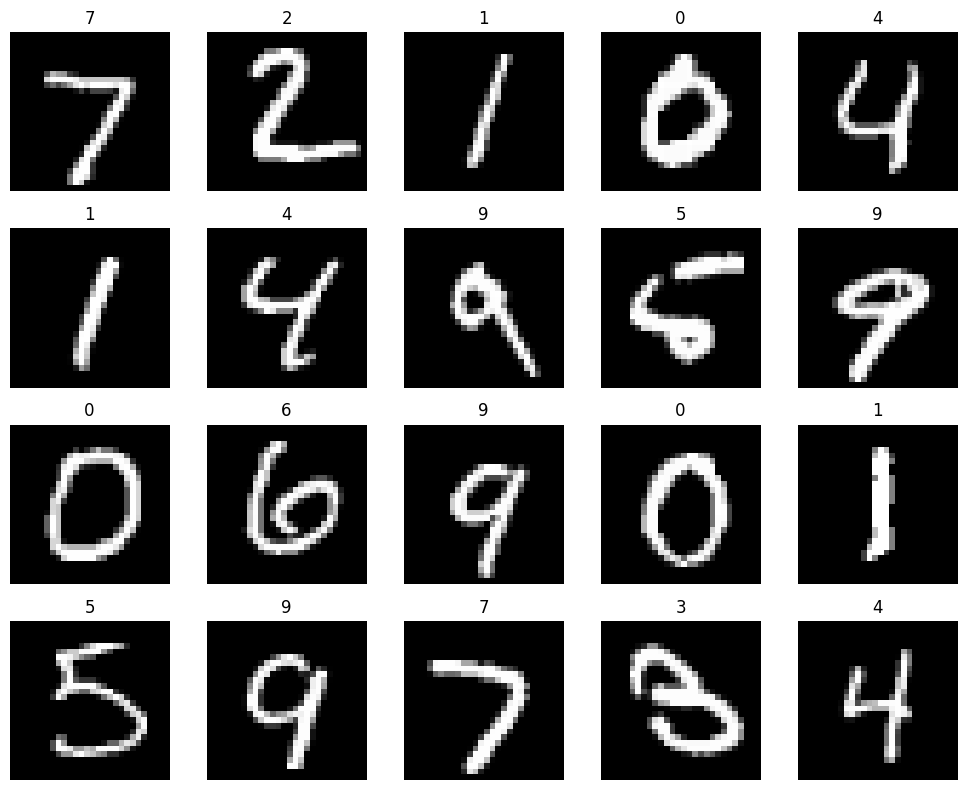

In [97]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Load the MNIST testing dataset
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Display the first 20 images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))  # Create a 4x5 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of subplots to 1D

for i in range(20):
    image, label = testset[i]  # Get the image and label
    axes[i].imshow(image.squeeze(), cmap='gray')  # Display the image
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(label)  # Set the title to the label

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Show the plot

In [96]:
from PIL import Image
import numpy as np

test_image = torchvision.datasets.MNIST(root='./data', train=False, download=True)
image, label = test_image[0]  # Get the first image and its label

# Convert to NumPy array
image_np = np.array(image)

# Flatten the array to 1D
image_c = image_np.flatten()

# Convert the array to a C-compatible format with newlines and aligned commas
c_array = "{ "
for i, value in enumerate(image_c):
    c_array += "{:3d}, ".format(value)  # Pad with spaces to align commas
    if (i + 1) % 28 == 0:
        c_array += "\n"  # Add a newline every 28 elements
c_array = c_array[:-2] + " }"  # Remove the last comma and space, then add the closing brace

print(c_array)

{   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 
  0,   0,  

# Debug

In [67]:
def conv1_output_hook(module, input, output):
    print("Conv1 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()

    # Extract the desired slice (first channel, 24x24)
    data = output_np[0, 0, :24, :24]

    # Format the output as a comma-separated list with newlines
    formatted_output = "["  # Start with an opening bracket
    for row in data:
        formatted_output += "[" + ", ".join(f"{x:8.1f}" for x in row) + "],\n"  # Add newline
    formatted_output = formatted_output[:-2] + "]"  # Remove last comma and newline, add closing bracket

    print(formatted_output)

def pool1_output_hook(module, input, output):
    print("Pool1 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print(output_np[0, 0, :12, :12])

def conv2_output_hook(module, input, output):
    print("Conv2 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from Conv2 output:")
    print(output_np[0, 0, :8, :8])

def pool2_output_hook(module, input, output):
    print("Pool2 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from Pool2 output:")
    print(output_np[0, 0, :4, :4])

def fc1_output_hook(module, input, output):
    print("FC1 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from FC1 output:")
    print(output_np[0, :5])  # Print first 5 values

def fc2_output_hook(module, input, output):
    print("FC2 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from FC2 output:")
    print(output_np[0, :5])  # Print first 5 values

def fc3_output_hook(module, input, output):
    print("FC3 output shape:", output.shape)
    output_np = output.cpu().detach().numpy()
    print("Some values from FC3 output:")
    print(output_np[0, :10])

In [83]:
# Register the hooks
# handle_conv1 = model.conv1.register_forward_hook(conv1_output_hook)
# handle_pool1 = model.pool.register_forward_hook(pool1_output_hook) # For the first pooling layer
# handle_conv2 = model.conv2.register_forward_hook(conv2_output_hook)
# handle_pool2 = model.pool.register_forward_hook(pool2_output_hook)  # For the second pooling layer
# handle_fc1 = model.fc1.register_forward_hook(fc1_output_hook)
# handle_fc2 = model.fc2.register_forward_hook(fc2_output_hook)
# handle_fc3 = model.fc3.register_forward_hook(fc3_output_hook)

image_tensor = torch.from_numpy(image_np).float()
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor)

_, predicted = torch.max(output, 1)
predicted_class = predicted.item()

print(f"Predicted class: {predicted_class}")

# Remove the hooks
# handle_conv1.remove()
# handle_pool1.remove()
# handle_conv2.remove()
# handle_pool2.remove()
# handle_fc1.remove()
# handle_fc2.remove()
# handle_fc3.remove()

Predicted class: 5


In [51]:
# Load the saved model weights
model = LeNet5()  # Assuming LeNet5 is your model class
model.load_state_dict(torch.load("lenet5.pth"))

# Access the conv1 weights and print them
conv1_weights = model.conv1.weight
print(conv1_weights)

Parameter containing:
tensor([[[[ 0.0709,  0.0656, -0.0729,  0.1918,  0.1979],
          [ 0.0976, -0.0216,  0.1881, -0.1551, -0.1054],
          [-0.0588, -0.0278,  0.1266,  0.1368, -0.0954],
          [-0.1012, -0.0074, -0.2410, -0.0397,  0.1124],
          [-0.0379, -0.1170, -0.0707, -0.1614, -0.1224]]],


        [[[-0.1226,  0.1203,  0.1094, -0.0907,  0.0717],
          [ 0.0227,  0.2011, -0.0008,  0.0446, -0.1852],
          [-0.0309, -0.1765,  0.0381, -0.2762, -0.0359],
          [-0.2054,  0.0241, -0.0340, -0.2223,  0.0009],
          [-0.0550,  0.0118, -0.2431,  0.1547,  0.0328]]],


        [[[-0.2414, -0.0729, -0.1094, -0.0361, -0.0839],
          [-0.1079, -0.1694, -0.1614,  0.0643,  0.0570],
          [ 0.0574, -0.0765,  0.1815,  0.0026, -0.0393],
          [ 0.0224,  0.0325, -0.0264,  0.2175, -0.0741],
          [-0.1951,  0.1640,  0.1301,  0.0578,  0.1159]]],


        [[[ 0.1095,  0.0495, -0.2270,  0.0571,  0.1133],
          [ 0.0892,  0.0704, -0.1780, -0.1940, -0.0885

<ipython-input-51-b282aab48842>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lenet5.pth"))
